Saving cure_the_princess_validation.csv to cure_the_princess_validation (8).csv
Saving cure_the_princess_test.csv to cure_the_princess_test (8).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (8).csv
Epoch: 1 	Training Loss: 0.675921 	Validation Loss: 0.666613
Epoch: 2 	Training Loss: 0.665193 	Validation Loss: 0.655079
Epoch: 3 	Training Loss: 0.654602 	Validation Loss: 0.642853
Epoch: 4 	Training Loss: 0.643856 	Validation Loss: 0.630794
Epoch: 5 	Training Loss: 0.633401 	Validation Loss: 0.619182
Epoch: 6 	Training Loss: 0.623586 	Validation Loss: 0.608072
Epoch: 7 	Training Loss: 0.614120 	Validation Loss: 0.597434
Epoch: 8 	Training Loss: 0.605349 	Validation Loss: 0.587567
Epoch: 9 	Training Loss: 0.596692 	Validation Loss: 0.578044
Epoch: 10 	Training Loss: 0.589063 	Validation Loss: 0.569277
Epoch: 11 	Training Loss: 0.581487 	Validation Loss: 0.560939
Epoch: 12 	Training Loss: 0.574385 	Validation Loss: 0.553294
Epoch: 13 	Training Loss: 0.567932 	Validation 

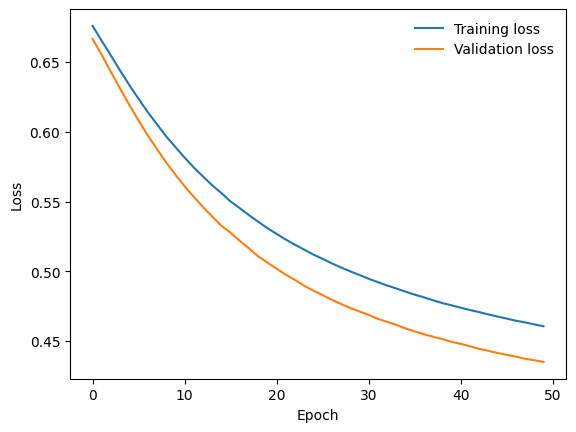

Accuracy: 52.45%
Precision: 52.57%
Recall: 53.39%
F1 score: 52.97%
CPU execution time: 3.3357417583465576


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from google.colab import files
import time

# Random seed ayarlanması
SEED = 180401123
torch.manual_seed(SEED)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

# Modify input_dim parameter
model = MLP(input_dim=13, hidden_dim1=100, hidden_dim2=50, output_dim=2)


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Upload the data files
uploaded = files.upload()
 
start_time = time.time()
# Verilerin yüklenmesi
train_df = pd.read_csv('cure_the_princess_train.csv')
val_df = pd.read_csv('cure_the_princess_validation.csv')
test_df = pd.read_csv('cure_the_princess_test.csv')

# Verilerin PyTorch tensor'larına dönüştürülmesi
X_train = torch.tensor(train_df.drop(['Cured'], axis=1).values).float()
y_train = torch.tensor(train_df['Cured'].values).long()
train_dataset = TensorDataset(X_train, y_train)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = torch.tensor(val_df.drop(['Cured'], axis=1).values).float()
y_val = torch.tensor(val_df['Cured'].values).long()
val_dataset = TensorDataset(X_val, y_val)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Verilerin PyTorch DataLoader'ına dönüştürülmesi
class PrincessDataset(Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data.iloc[:, :-1].values).float()
        self.y = torch.tensor(data.iloc[:, -1].values).long()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PrincessDataset(train_df)
val_dataset = PrincessDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


criterion = nn.CrossEntropyLoss()

# Optimizasyon algoritmasının tanımlanması
optimizer = optim.SGD(model.parameters(), lr=0.001)



# Eğitim epoch sayısının belirlenmesi
n_epochs = 50

# Eğitim ve validasyon loss'larının kaydedilmes
train_losses = []
valid_losses = []


#Model eğitimi
for epoch in range(n_epochs):
  train_loss = 0.0
  valid_loss = 0.0
  # Model eğitimi
  model.train()
  for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      
  # Model validasyonu
  model.eval()
  for data, target in validation_loader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

  # Eğitim ve validasyon loss'larının hesaplanması
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(validation_loader.dataset)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  # Epoch sonuçlarının yazdırılması
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch+1, train_loss, valid_loss))


# Plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Load the test dataset
test_df = pd.read_csv('cure_the_princess_test.csv')

# Convert the test dataset to PyTorch tensor
X_test = torch.tensor(test_df.drop(['Cured'], axis=1).values).float()
y_test = torch.tensor(test_df['Cured'].values).long()
test_dataset = TensorDataset(X_test, y_test)

# Create the test dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

 
# Define variables for calculating accuracy, precision, recall and F1 score
tp = 0
tn = 0
fp = 0
fn = 0

# Iterate over the test data
for data, target in test_loader:
    # Forward pass
    output = model(data)
    # Calculate the predicted class
    pred = output.argmax(dim=1, keepdim=True)
    # Update the variables for calculating accuracy, precision, recall and F1 score
    tp += ((pred == 1) & (target == 1)).sum().item()
    tn += ((pred == 0) & (target == 0)).sum().item()
    fp += ((pred == 1) & (target == 0)).sum().item()
    fn += ((pred == 0) & (target == 1)).sum().item()

# Calculate accuracy, precision, recall and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Print the results
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))
print('F1 score: {:.2f}%'.format(f1*100))

end_time = time.time()
cpu_time = end_time - start_time

print("CPU execution time:", cpu_time)

# GPU execution time
# if device.type == 'cuda':
#     torch.cuda.synchronize()

# start_time = time.time()
# output = model(input_tensor)
# loss = torch.nn.functional.cross_entropy(output, target_tensor)
# if device.type == 'cuda':
#     torch.cuda.synchronize()
# end_time = time.time()
# gpu_time = end_time - start_time

# print("GPU execution time:", gpu_time)